In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import jax

In [4]:
!wget https://archive.ics.uci.edu/static/public/501/beijing+multi+site+air+quality+data.zip

--2023-09-06 19:05:06--  https://archive.ics.uci.edu/static/public/501/beijing+multi+site+air+quality+data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘beijing+multi+site+air+quality+data.zip’

beijing+multi+site+     [     <=>            ]   7.81M  6.68MB/s    in 1.2s    

2023-09-06 19:05:07 (6.68 MB/s) - ‘beijing+multi+site+air+quality+data.zip’ saved [8192212]



In [5]:
!unzip beijing+multi+site+air+quality+data.zip

Archive:  beijing+multi+site+air+quality+data.zip
 extracting: PRSA2017_Data_20130301-20170228.zip  
 extracting: 2A2478DC-8517-4490-9FA7-36F9A7A542BE.JPG  
 extracting: data.csv                
 extracting: test.csv                


In [6]:
!unzip PRSA2017_Data_20130301-20170228.zip

Archive:  PRSA2017_Data_20130301-20170228.zip
   creating: PRSA_Data_20130301-20170228/
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Nongzhanguan_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Shunyi_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Tiantan_20130301-20170228.csv  
  inflating: PRSA_Data_20130301-20170228/PRSA_Data_Wanliu_20130301-201

In [7]:
!ls

2A2478DC-8517-4490-9FA7-36F9A7A542BE.JPG  PRSA_Data_20130301-20170228
beijing+multi+site+air+quality+data.zip   sample_data
data.csv				  test.csv
PRSA2017_Data_20130301-20170228.zip


In [4]:
import glob
import pandas as pd

path = 'data/PRSA_Data_20130301-20170228/'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [5]:
def pre_process(df):
    df['date_time']=pd.to_datetime(df[['year', 'month', 'day','hour']])
    df.drop(columns=['year', 'month', 'day','hour','No'],inplace=True)
    df.set_index('date_time',inplace=True)
    return df

In [6]:
df_preprocessed=[pre_process(df) for df in df_list]

In [7]:
df_preprocessed[0]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date_time,,,,,,,,,,,,,
2013-03-01 00:00:00,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
2013-03-01 01:00:00,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2013-03-01 02:00:00,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
2013-03-01 03:00:00,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
2013-03-01 04:00:00,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,14.0,58.0,4.0,19.0,500.0,56.0,12.8,1009.9,-17.0,0.0,NNW,3.1,Gucheng
2017-02-28 20:00:00,27.0,83.0,6.0,60.0,700.0,26.0,11.1,1010.4,-15.5,0.0,NW,1.9,Gucheng
2017-02-28 21:00:00,22.0,37.0,7.0,52.0,600.0,27.0,10.5,1010.8,-15.9,0.0,N,2.3,Gucheng


In [8]:
df_group=pd.concat(df_preprocessed)

In [9]:
def train_test_split(data,split_fraction,feature_keys):
    data=data[feature_keys]
    train_split = int(split_fraction * int(data.shape[0]))
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def create_batch(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=data[future+lag-1:].values
    return X,y

def create_batch_multistep(df,lag,future,feature=None):
    if feature is None:
        data=df
    else:
        data=df[feature]
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    df_future=pd.concat([data[lag-1:].shift(-i) for i in range(1,future+1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=df_future.values
    return X,y

In [10]:
df_group.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [49]:
import numpy as np

split_fraction = 0.8
feature_keys = ['PM2.5','TEMP','PRES','DEWP','RAIN','PM10']
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()
future=6
past=6
dataset_names=list()
for item_id, gdf in df_group.groupby('station'):
    gdf.fillna(method='ffill',inplace=True)
    train,test=train_test_split(gdf,split_fraction,feature_keys)
    train_multi_feature=list()
    test_multi_feature=list()
    for feature in feature_keys:
        X_train,y_train=create_batch_multistep(train,past,future,feature)
        X_test,y_test=create_batch_multistep(test,past,future,feature)
        train_multi_feature.append(X_train)
        test_multi_feature.append(X_test)
        if feature=='PM2.5':
            y_train_datasets.append(y_train)
            y_test_datasets.append(y_test)
    X_train_datasets.append(np.stack(train_multi_feature,axis=-1))
    X_test_datasets.append(np.stack(test_multi_feature,axis=-1))
    dataset_names.append(item_id)
X_train_datasets=np.stack(X_train_datasets,axis=0)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
y_test_datasets=np.stack(y_test_datasets,axis=0)

In [50]:
X_train_datasets.shape,y_train_datasets.shape

((12, 28039, 6, 6), (12, 28039, 6))

In [51]:
import jax
import jax.numpy as jnp

def get_dataloader(X,y,batch_size,key,axis=0):
    num_train=X.shape[axis]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[:,batch_indices,:,:], y[:,batch_indices]

In [52]:
import optax
from flax import linen as nn
from functools import partial

class LSTM(nn.Module):

    @nn.remat
    @nn.compact
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(X_batch)
        #carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]

def log_likelihood(params, x, y):
    preds = jax.vmap(model.apply, (0, 0))(params, jnp.array(x))
    return jnp.mean(optax.l2_loss(y,preds).sum(axis=-1))

grad_log_post=jax.jit(jax.grad(log_likelihood))

@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree_map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree_map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree_map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree_map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree_map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss


In [53]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [54]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
n_features=len(feature_keys)
inputs = jax.random.randint(key,(batch_size,past,n_features),0, 10,).astype(jnp.float32)
key_tasks=jax.random.split(key_model,n_groups)
params_tasks = jax.vmap(model.init, (0, None))(key_tasks, inputs)

In [55]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 50,
                             dt, params_tasks,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

iteration 0, loss 0.86
iteration 5, loss 0.55
iteration 10, loss 0.61
iteration 15, loss 0.54
iteration 20, loss 0.52
iteration 25, loss 0.46
iteration 30, loss 0.47
iteration 35, loss 0.42
iteration 40, loss 0.46
iteration 45, loss 0.47


In [56]:
jax.tree_util.tree_flatten(samples[0]['params'])[1]

PyTreeDef({'Dense_0': {'bias': *, 'kernel': *}, 'LSTMCell_0': {'hf': {'bias': *, 'kernel': *}, 'hg': {'bias': *, 'kernel': *}, 'hi': {'bias': *, 'kernel': *}, 'ho': {'bias': *, 'kernel': *}, 'if': {'kernel': *}, 'ig': {'kernel': *}, 'ii': {'kernel': *}, 'io': {'kernel': *}}})

In [57]:
flat_param=[jax.flatten_util.ravel_pytree(samples[i])[0] for i in range(len(samples))]
flat_param=jnp.stack(flat_param)

In [58]:
flat_param.shape

(50, 62280)

In [59]:
X_test=X_test_datasets
params=samples[-1]
preds=jax.vmap(model.apply, (0, 0))(params, X_test)

In [60]:
from sklearn import metrics
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:],squared=True)
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Aotizhongxin, RMSE : 0.23, MAE :0.27, R2 :0.70
task : Changping, RMSE : 0.23, MAE :0.26, R2 :0.69
task : Dingling, RMSE : 0.22, MAE :0.24, R2 :0.71
task : Dongsi, RMSE : 0.27, MAE :0.29, R2 :0.63
task : Guanyuan, RMSE : 0.27, MAE :0.29, R2 :0.69
task : Gucheng, RMSE : 0.31, MAE :0.29, R2 :0.59
task : Huairou, RMSE : 0.20, MAE :0.24, R2 :0.71
task : Nongzhanguan, RMSE : 0.23, MAE :0.27, R2 :0.70
task : Shunyi, RMSE : 0.24, MAE :0.28, R2 :0.68
task : Tiantan, RMSE : 0.25, MAE :0.28, R2 :0.66
task : Wanliu, RMSE : 0.23, MAE :0.26, R2 :0.69
task : Wanshouxigong, RMSE : 0.27, MAE :0.29, R2 :0.68
-------------------------------------------------------
RMSE : 0.25, MAE :0.27, R2 :0.68


In [61]:
ensemble_pred=list()
X_test=X_test_datasets
for i in range(len(samples)):
    preds=jax.vmap(model.apply, (0, 0))(samples[i], X_test)
    ensemble_pred.append(preds)

In [62]:
ensemble_pred=np.stack(ensemble_pred,axis=-1)

In [63]:
mean_pred=np.mean(ensemble_pred,axis=-1)
std_pred=np.std(ensemble_pred,axis=-1)

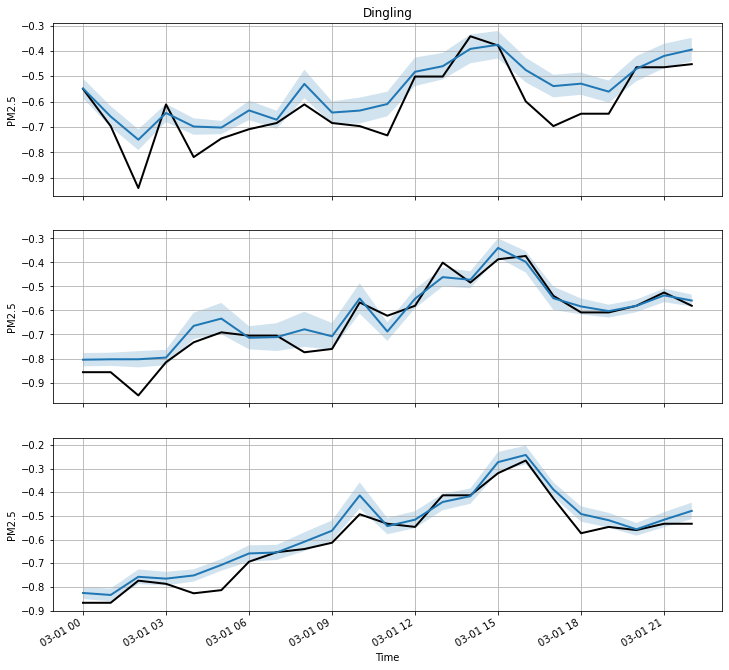

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=1
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[1,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[1,2:25,future_pred]-std_pred[1,2:25,future_pred]),np.ravel(mean_pred[1,2:25,future_pred]+std_pred[1,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()